In [2]:
import random
import statistics as stats
import mesa as mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid
import matplotlib.pyplot as plt

In [4]:
class StateAgent(mesa.Agent):
    """An agent with a random initial score."""
    
    def __init__(self, unique_id, model):
        
        # Pass parameters to parent class
        super().__init__(unique_id, model) # why do we not pass self through the parent class?
        
        # Create agent's variable and set initial values
        self.current_score = random.randint(-10, 0)  # Let's chat through these values
        
        # This ^ is a somewhat simplified approach to updating the score, rather than using new_score

    def step(self):
        
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        
        # We can use list comprehension to calculate the average neighbor score!
        neighbor_average = stats.mean([neighbor.current_score for neighbor in neighbors])

        
        #Rules go here- from the PoV of an autocrat's perspective       
        if neighbor_average > (self.current_score + 2):
            p = random.random()
            if p <=0.7:
                self.current_score -= 1
            if p > 0.7 and p <= 0.9:
                self.current_score = self.current_score
            else:
                self.current_score += 1
                
        if neighbor_average < (self.current_score - 2):
            q = random.random()
            if q <= 0.6:
                self.current_score = self.current_score
            if q > 0.6 and q <= 0.9:
                self.current_score -= 1
            else:
                self.current_score += 1
        
        # This should bound the scores between -10 and 10, and ensure they are integers rather than floats.
        self.current_score = max(min(int(self.current_score), 10), -10)


class StateModel(mesa.Model):
    """A model with some number of agents."""
    
    def __init__(self, N, width, height):
        
        self.num_agents = N
        self.height = height
        self.width = width
        self.current_id = 0  # This is required to iterate through agents
        self.running = True

        
        # Create a set of occupied cells that we can use to avoid collisions
        self.occupied_cells = set()
        
        # Create grid and schedule
        self.grid = mesa.space.SingleGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        
        # A different way to create the grid and schedule, having imported mesa.space and
        # mesa.time individually. Both this and your original code work equally well!
        #
        # self.grid = SingleGrid(width, height, True)
        # self.schedule = RandomActivation(self)
        

        # Assigning agents to a cell after checking whether the cell is in
        # the self.occupied_cells set
        while len(self.occupied_cells) < self.num_agents:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            if (x, y) not in self.occupied_cells:
                a = StateAgent(self.next_id(), self)
                self.grid.place_agent(a, (x, y))
                self.schedule.add(a)
                self.occupied_cells.add((x, y))  # Mark the cell as occupied

        # no clue what this is doing
        self.datacollector = mesa.DataCollector(
            agent_reporters={"Score": "current_score"})   
        
        # defining each score bin
        # this groups by score
        #self.time_series_data = {"-10": [], "-9": [], "-8": [], "-7": [], "-6": [], "-5": [], "-4": [],
                                # "-3": [], "-2": [], "-1": [], "0": [], "1": [], "2": [], "3": [], "4": [],
                                 #"5": [], "6": [], "7": [], "8": [], "9": [], "10": []}
        
        # this groups by regime type      
        self.time_series_data = {"Autocracies": [], "Closed Anocracies": [], "Open Anocracies": [], 
                                "Democracies": [], "Full Democracies": []}
          

    def step(self):
        """Advance the model by one step."""
        self.schedule.step()
        self.datacollector.collect(self)
   
        # should plot the score distributions at each time step 
        scores = self.datacollector.get_agent_vars_dataframe()
        score_counts = scores["Score"].value_counts().sort_index()
        
        # using generator expression to classify scores into the regime type bins 
        autocracies = sum(score_counts.get(value, 0) for value in range(-10, -5))
        closed_anocracies = sum(score_counts.get(value, 0) for value in range(-5, 1))
        open_anocracies = sum(score_counts.get(value, 0) for value in range(1, 6))
        democracies = sum(score_counts.get(value, 0) for value in range(6, 10))
        full_democracies = score_counts.get(10, 0)
        

        # Organize scores into groups for time_series_data 
        self.time_series_data["Autocracies"].append(autocracies)
        self.time_series_data["Closed Anocracies"].append(closed_anocracies)
        self.time_series_data["Open Anocracies"].append(open_anocracies)
        self.time_series_data["Democracies"].append(democracies)
        self.time_series_data["Full Democracies"].append(full_democracies)

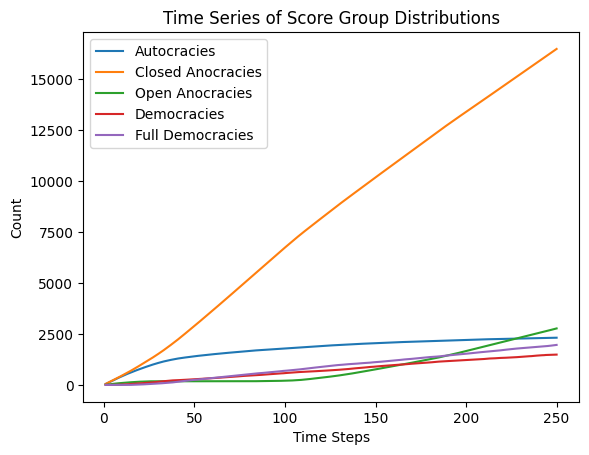

In [9]:
# running model
model = StateModel(100, 10, 10)
for i in range(250):
    model.step()

# Plot the time series data
# The issue with this graph is that shows the cumulative number of each regime over each iteration of the model
# I was not able to modofy it so that it only displayed the counts of each regime type at each time step only
# Regardless, it is visible that autocracies decline over time
# But, I am unable to locate the equilibrium point with this version of the graph 

time_steps = list(range(1, 251)) 

for group, data in model.time_series_data.items(): 
    plt.plot(time_steps, data, label=group) 

plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.title("Time Series of Score Group Distributions")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


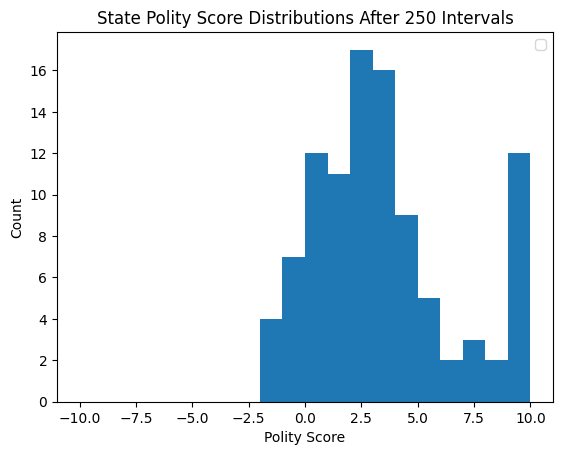

In [10]:
model = StateModel(100, 10, 10)
for i in range(250): #input for desired no. of time steps
    model.step()

agent_score = [a.current_score for a in model.schedule.agents]
plt.hist(agent_score, bins = range(-10, 11))
plt.xlabel("Polity Score")
plt.ylabel("Count")
plt.title("State Polity Score Distributions After 250 Intervals")
plt.legend()
plt.show()

(array([  0.,   0.,   3.,   5.,  41.,  90., 146., 262., 349., 434., 451.,
        324., 173.,  71.,  23.,  12.,  17.,  36.,  61., 502.]),
 array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
          1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <BarContainer object of 20 artists>)

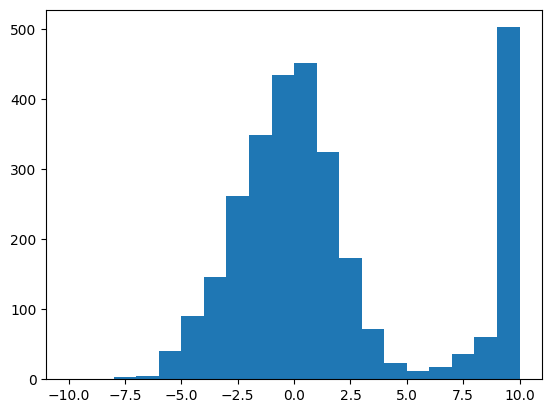

In [11]:
all_scores = []
#runs model 30 times, with each model executing 100 steps
for j in range(30):
    #run model
    model = StateModel(100, 10 , 10)
    for i in range(100):
        model.step()
        
    #store results
    for agent in model.schedule.agents:
        all_scores.append(agent.current_score)
        
 # Plotting the above code into a histogram   
plt.hist(all_scores, bins = range(-10, 11))

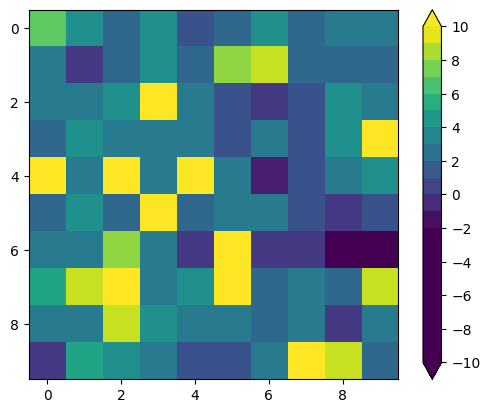

In [41]:
# Creating a heatmap 

import numpy as np

model = StateModel(100, 10, 10)
for i in range(250):
    model.step()
    
agent_scores = np.zeros((model.grid.width, model.grid.height))
for a, cell in zip(model.schedule.agents, model.grid.coord_iter()):
    agent_score = a.current_score
    cell_content, x, y = cell
    agent_scores[x][y] = agent_score

plt.imshow(agent_scores, interpolation = "nearest")

plt.colorbar(boundaries=range(-10, 11), extend = 'both', ticks=np.linspace(-10, 10, 11, endpoint=True), spacing='proportional')

In [12]:
# Creating the paramters for the simulation of the ABM and launching it
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    if agent.current_score < -10: 
        portrayal["Color"] = "black"
        portrayal["Layer"] = 0
    elif agent.current_score <= -6 and agent.current_score >= -10: 
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1
    elif agent.current_score <= 0 and agent.current_score >= -5:
        portrayal["Color"] = "orange"
        portrayal["Layer"] = 2
    elif agent.current_score <= 5 and agent.current_score >= 1:
        portrayal["Color"] = "yellow"
        portrayal["Layer"] = 3
    elif agent.current_score <= 9 and agent.current_score >= 6:
        portrayal["Color"] = "green"
        portrayal["Layer"] = 3
    elif agent.current_score == 10:
        portrayal["Color"] = "blue"
        portrayal["Layer"] = 4
    else:
        portrayal["Color"] = "black"
        portrayal["Layer"] = 5   
    return portrayal

grid = mesa.visualization.CanvasGrid(agent_portrayal, 10, 10, 500, 500)
chart = mesa.visualization.ChartModule([{"Label": "Polity Score Distributions", 
                                         "Color": "Black"}],
                                       data_collector_name="datacollector")
server = mesa.visualization.ModularServer(StateModel,
                                          [grid, chart],
                                         "State Model",
                                         {"N":100, "width":10, "height":10})

server.port = 8584 # The default
server.launch()

Interface starting at http://127.0.0.1:8582


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
